In [53]:
import pandas as pd
import dgl
import torch
from functools import partial
from torch.utils.data import DataLoader
from dgllife.utils import smiles_to_bigraph
from utils.eval_meter import Meter
from utils.featurizers import CanonicalAtomFeaturizer
from utils.featurizers import CanonicalBondFeaturizer
from dgllife.utils import one_hot_encoding
from dgllife.data.csv_dataset import MoleculeCSVDataset
import os
import random
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
%matplotlib inline
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='hv')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='he')

In [54]:
def set_random_seed(args):
    seed = args['seed']
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks
def load_data(data):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=smiles_to_bigraph,
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path= './ChemXGNN/Data/Aromaticity/graph.bin',
                                 task_names=None,
                                 load=False,init_mask=True,n_jobs=1
                            )

    return dataset

## Molecule preparation 

In [55]:
import numpy as np
import pandas as pd
from rdkit import Chem
from molvs.normalize import Normalizer, Normalization
from rdkit.Chem.SaltRemover import SaltRemover
from molvs.charge import Reionizer, Uncharger

In [56]:
smi='CC(=O)NC1=CC=C(C=C1)O'
mol = Chem.MolFromSmiles(smi)
normalizer = Normalizer()
new1 = normalizer.normalize(mol)
remover = SaltRemover()
new2 = remover(new1)
neutralize1 = Reionizer()
new3 = neutralize1(new2)
neutralize2 = Uncharger()
new4 = neutralize2(new3)
Chem.SanitizeMol(new4)
new_smiles = Chem.MolToSmiles(new4,kekuleSmiles=False)

In [57]:
smi=[new_smiles]
df=pd.DataFrame(smi,columns=['SMILES'])
dataset=load_data(df)

Processing dgl graphs from scratch...


## Load Models 

In [58]:
from utils.attentivefp_predictor import AttentiveFPPredictor
atfp=AttentiveFPPredictor(node_feat_size=78,
                             edge_feat_size=12,
                             num_layers=2,
                             num_timesteps=2,
                             graph_feat_size=128,
                             predictor_hidden_feats=64,
                             n_tasks=1)
fn = '../ChemXGNN/Models/AttentiveFP/lipophilicity.pt'
atfp.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

<All keys matched successfully>

In [59]:
from utils.gat_predictor import GATPredictor
gat = GATPredictor(in_feats=78,
                   hidden_feats=[128,128],
                   num_heads=[8,8],
                   alphas=[0.333,0.333],
                   residuals=[False,False],
                   predictor_hidden_feats=64,
                   n_tasks=1)
fn = '../ChemXGNN/Models/GAT/lipophilicity.pt'
gat.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

<All keys matched successfully>

In [60]:
from utils.gcn_predictor import GCNPredictor
import torch.nn.functional as F
gcn = GCNPredictor(in_feats=78,
                     hidden_feats=[256,256],
                     activation=[F.relu,F.relu],
                     n_tasks=1,
                     predictor_hidden_feats=256)
fn = '../ChemXGNN/Models/GCN/lipophilicity.pt'
gcn.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

<All keys matched successfully>

In [61]:
from utils.graphsage_predictor import GraphSAGEPredictor
import torch.nn as nn
graphsage = GraphSAGEPredictor(in_feats=78,
                           hidden_feats=[128,128],
                           activation=[nn.LeakyReLU,nn.LeakyReLU],
                           aggregator_type=['lstm','lstm'],
                           predictor_hidden_feats=128,
                           n_tasks=1)
fn = '../ChemXGNN/Models/Graphsage/lipophilicity.pt'
graphsage.load_state_dict(torch.load(fn, map_location=torch.device('cpu')))

<All keys matched successfully>

## IG 

In [62]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv'].requires_grad_()
    pred, node_gradient = model.forward(bg, n_feats, get_node_gradient=True)
    prob_aro = torch.sigmoid(node_gradient).numpy().tolist()
    node_gradient = node_gradient.detach().cpu().numpy().tolist()
    nodes = []
    for pred_aro in node_gradient:
        if pred_aro >= 0:
            nodes.append(int(1))
        else:
            nodes.append(int(0))
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

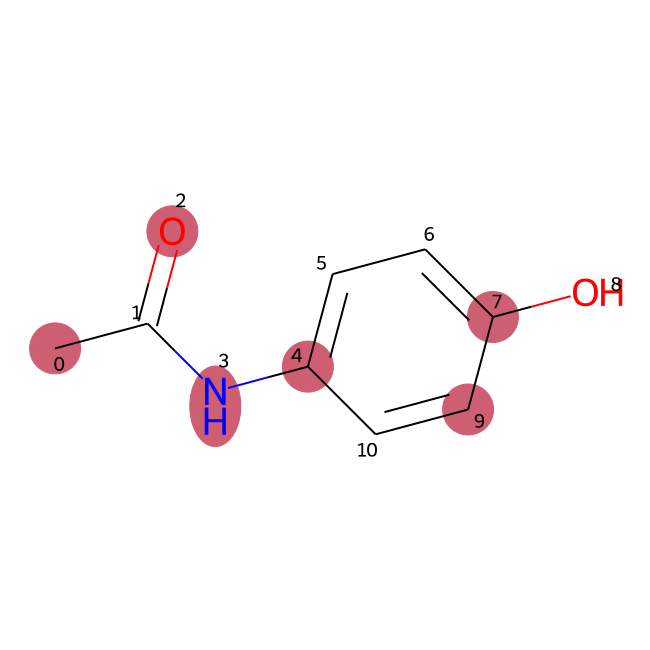

In [63]:
draw(gcn,dataset)

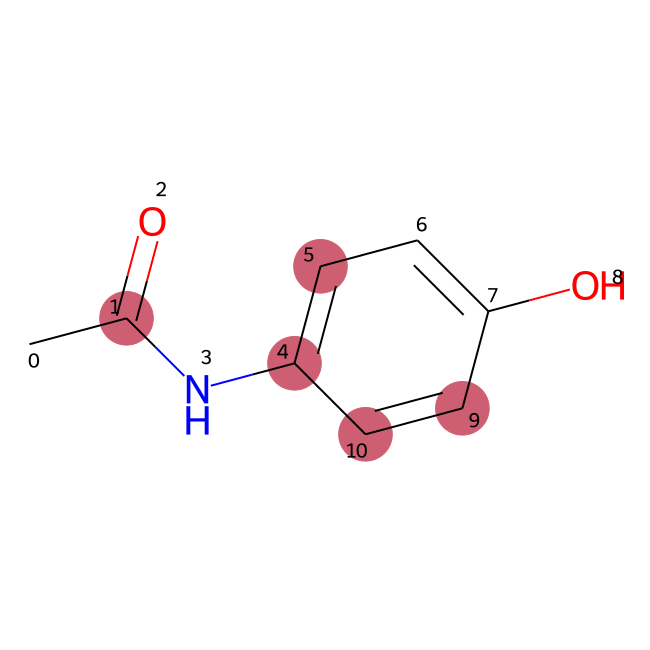

In [64]:
draw(gat,dataset)

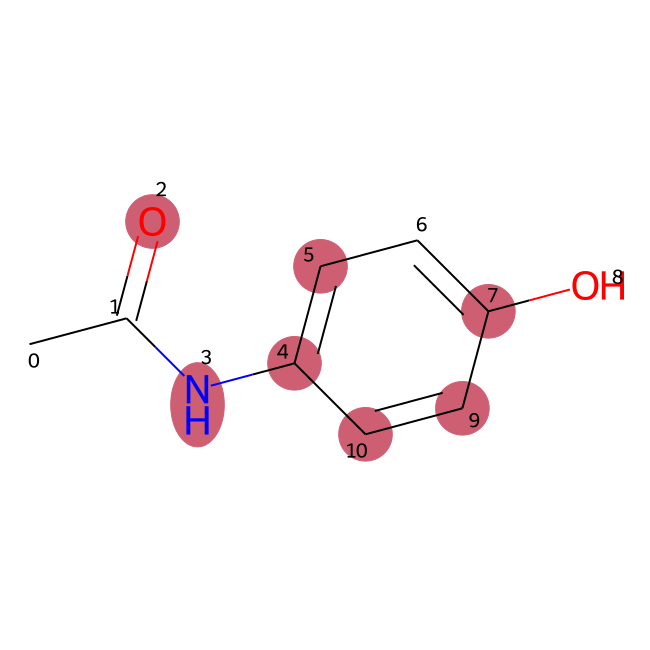

In [65]:
draw(graphsage,dataset)

## GNN-Explainer 

In [69]:
from utils.GNexplainers import GNNExplainer

use CPU


In [70]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    exp = GNNExplainer(model, epochs=1000, lr=0.05, molecule=False)
    node_feat_masks, related_preds = exp.forward(x=n_feats, bg=bg, ex_labels=pred,
                                                 mask_features=True, positive=True)
    node_feat_masks = node_feat_masks[0].detach().cpu().abs()
    min_value = torch.min(torch.tensor(node_feat_masks))
    max_value = torch.max(torch.tensor(node_feat_masks))
    node_feat_masks = (torch.tensor(node_feat_masks) - min_value) / (max_value - min_value)
    nodes = []
    for pred_aro in node_feat_masks:
        if pred_aro <= sum(node_feat_masks) / len(node_feat_masks):
            nodes.append(1)
        else:
            nodes.append(0)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

#D#Masks calculate...


D:\anaconda\envs\rdk\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#D#Loss:3.475274085998535
#D#Loss:2.0961215496063232
#D#Loss:1.3670554161071777
#D#Loss:1.067508578300476
#D#Loss:0.8551793694496155
#D#Loss:0.6890566945075989
#D#Loss:0.602042019367218
#D#Loss:0.5412561893463135
#D#Loss:0.5041592717170715
#D#Loss:0.48146378993988037
#D#Loss:0.4653492867946625
#D#Loss:0.4527856111526489
#D#Loss:0.4428901672363281
#D#Loss:0.43452179431915283
#D#Loss:0.42740997672080994
#D#Loss:0.4213830530643463
#D#Loss:0.4161324203014374
#D#Loss:0.41151508688926697
#D#Loss:0.4074397087097168
#D#Loss:0.4038427770137787
#D#Loss:0.4006592631340027
#D#Loss:0.39771151542663574
#D#Loss:0.39479732513427734
#D#Loss:0.39214059710502625
#D#Loss:0.38978809118270874
#D#Loss:0.38771355152130127
#D#Loss:0.3858380615711212
#D#Loss:0.3841297924518585
#D#Loss:0.3825678527355194
#D#Loss:0.38113388419151306
#D#Loss:0.37981292605400085
#D#Loss:0.37860769033432007
#D#Loss:0.3775125741958618
#D#Loss:0.3765040338039398
#D#Loss:0.3755682408809662
#D#Loss:0.37469756603240967
#D#Loss:0.37388688

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


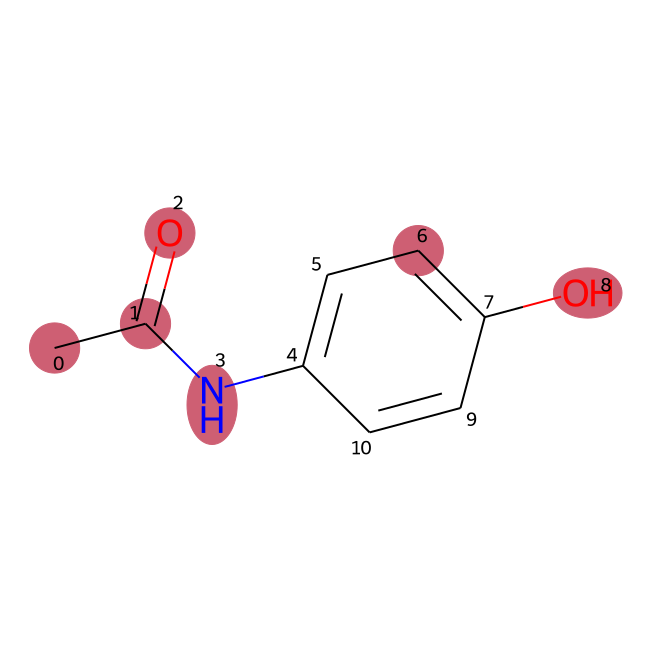

In [71]:
draw(gcn,dataset)

#D#Masks calculate...
#D#Loss:3.1191489696502686
#D#Loss:1.534596562385559
#D#Loss:0.9734885096549988
#D#Loss:0.6928086280822754
#D#Loss:0.509236216545105
#D#Loss:0.4146087169647217
#D#Loss:0.3535324037075043
#D#Loss:0.30807456374168396
#D#Loss:0.27841681241989136
#D#Loss:0.2564965486526489
#D#Loss:0.2396254539489746
#D#Loss:0.2262900322675705
#D#Loss:0.21539269387722015
#D#Loss:0.20632481575012207
#D#Loss:0.19869261980056763
#D#Loss:0.19218404591083527
#D#Loss:0.1866278201341629
#D#Loss:0.18179534375667572
#D#Loss:0.1775403916835785
#D#Loss:0.17375949025154114
#D#Loss:0.17036958038806915
#D#Loss:0.16732870042324066
#D#Loss:0.1645924150943756
#D#Loss:0.16212448477745056
#D#Loss:0.15988576412200928
#D#Loss:0.1578454077243805
#D#Loss:0.15598006546497345
#D#Loss:0.15426883101463318
#D#Loss:0.15269821882247925
#D#Loss:0.1512535810470581
#D#Loss:0.14992067217826843
#D#Loss:0.1486888825893402
#D#Loss:0.14754749834537506
#D#Loss:0.1464875489473343
#D#Loss:0.14550147950649261
#D#Loss:0.1445833

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


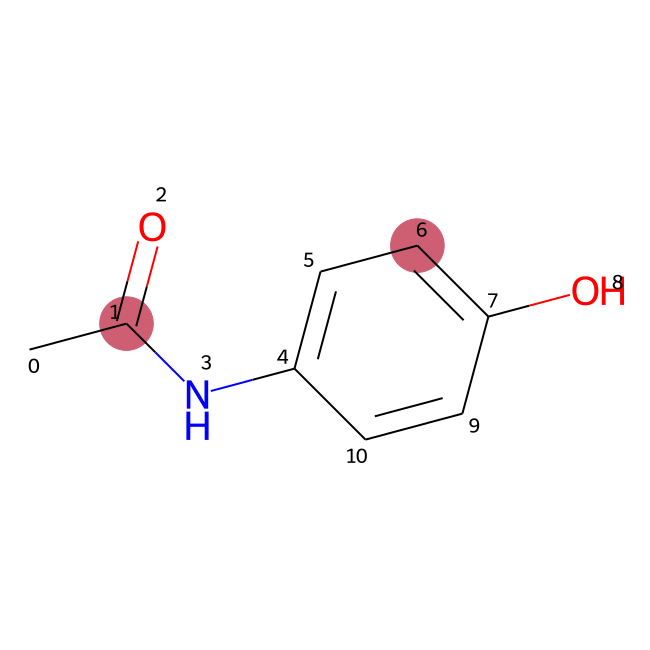

In [72]:
draw(gat,dataset)

#D#Masks calculate...
#D#Loss:3.68821120262146
#D#Loss:1.873169183731079
#D#Loss:1.063668131828308
#D#Loss:0.8059606552124023
#D#Loss:0.710732102394104
#D#Loss:0.6565529704093933
#D#Loss:0.6206408739089966
#D#Loss:0.5946438312530518
#D#Loss:0.5735395550727844
#D#Loss:0.5596290826797485
#D#Loss:0.5502730011940002
#D#Loss:0.5421395301818848
#D#Loss:0.5349467992782593
#D#Loss:0.529071033000946
#D#Loss:0.5242093801498413
#D#Loss:0.5200726389884949
#D#Loss:0.5165236592292786
#D#Loss:0.5134607553482056
#D#Loss:0.5107726454734802
#D#Loss:0.5082395672798157
#D#Loss:0.5059943795204163
#D#Loss:0.5039049386978149
#D#Loss:0.5017441511154175
#D#Loss:0.4997284710407257
#D#Loss:0.49794232845306396
#D#Loss:0.49638938903808594
#D#Loss:0.4950253367424011
#D#Loss:0.4938100576400757
#D#Loss:0.4927302300930023
#D#Loss:0.4917287826538086
#D#Loss:0.4908365309238434
#D#Loss:0.4900516867637634
#D#Loss:0.4893280267715454
#D#Loss:0.4886709451675415
#D#Loss:0.488058477640152
#D#Loss:0.4875049293041229
#D#Loss:0.4

D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\rdk\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


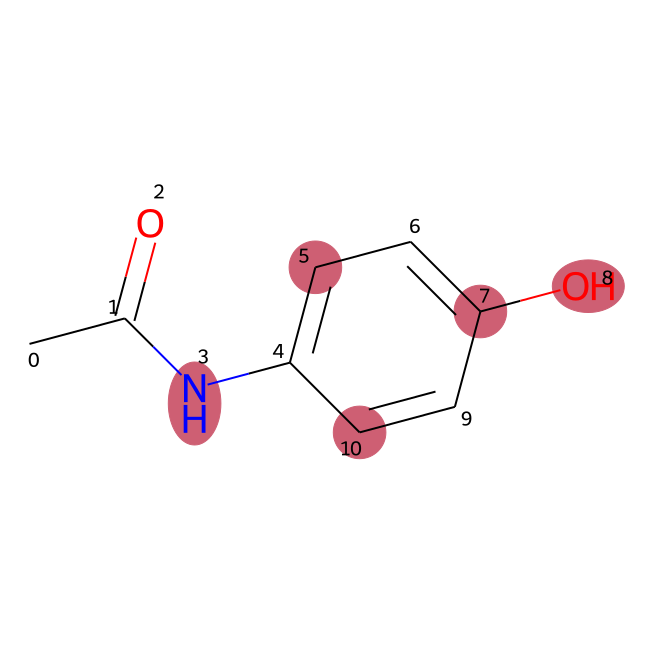

In [73]:
draw(graphsage,dataset)

## PGM-Explainer 

In [74]:
import utils.pgm_explainer_graph as pe

use CPU


In [75]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    pred_threshold = 0.05
    e = pe.Graph_Explainer(model, bg,
                           perturb_feature_list=[0],
                           perturb_mode="max",
                           perturb_indicator="diff")
    pgm_nodes, p_values, candidates, num_nodes = e.explain(num_samples=500, percentage=10,
                                                           top_node=50, p_threshold=0.05,
                                                           pred_threshold=pred_threshold)
    atoms = np.arange(num_nodes).tolist()
    important_nodes = []
    for i in pgm_nodes:
        if p_values[i] > 0.05:
            important_nodes.append(i)
    nodes = []
    for n in atoms:
        if n in important_nodes:
            nodes.append(1)
        else:
            nodes.append(0)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

D:\Intepreta\ChemXGNN\utils\pgm_explainer_graph.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float)
D:\anaconda\envs\rdk\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


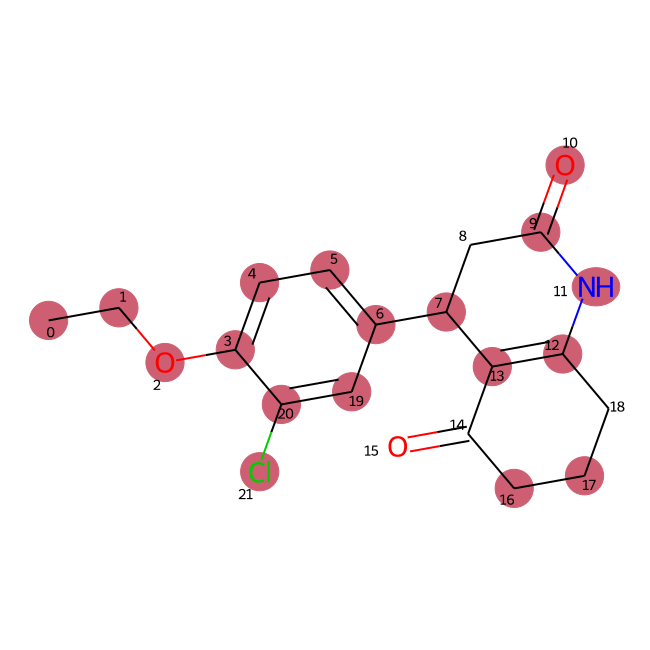

In [21]:
draw(gcn,dataset)

D:\Intepreta\ChemXGNN\utils\pgm_explainer_graph.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float)
D:\anaconda\envs\rdk\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


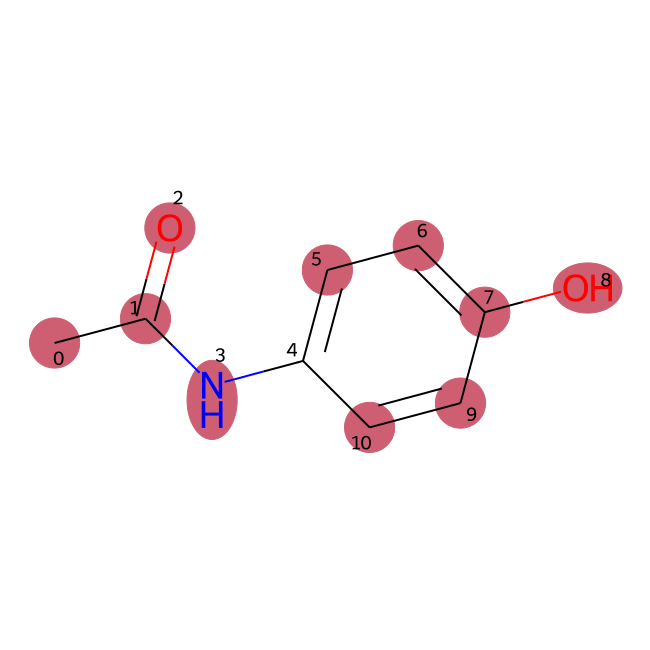

In [76]:
draw(gat,dataset)

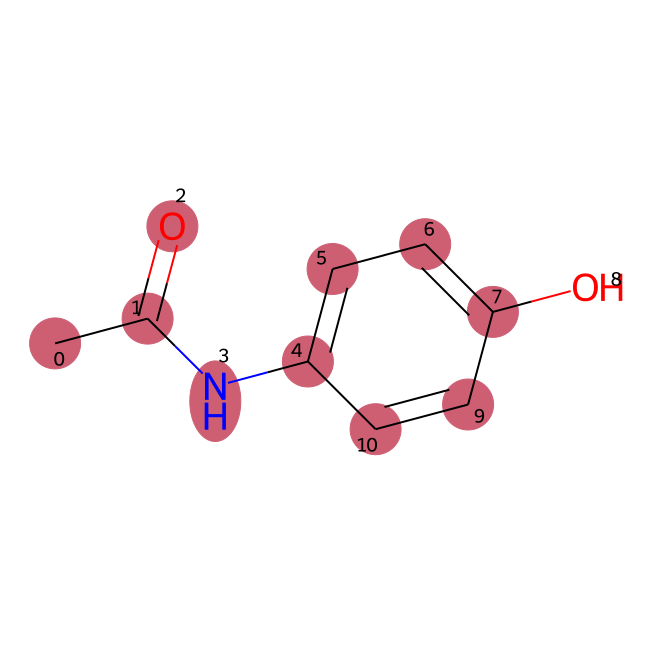

In [77]:
draw(graphsage,dataset)

## SubgraphX 

In [78]:
from utils.mcts import MCTS, reward_func
from utils.configures_shap import mcts_args, reward_args
from utils.shapley import GnnNets_GC2value_func
from scipy.sparse import coo_matrix
def find_closest_node_result(results, max_nodes):
    results = sorted(results, key=lambda x: x.P, reverse=True)
    results = sorted(results, key=lambda x: len(x.coalition))
    result_node = results[0]
    for result_idx in range(len(results)):
        x = results[result_idx]
        if len(x.coalition) <= max_nodes and x.P > result_node.P:
            result_node = x
    return result_node

use CPU


In [79]:
def draw(model,datasets):
    model.eval()
    smiles, bg, label, masks = dataset[0]
    n_feats = bg.ndata['hv']
    pred = model.forward(bg, n_feats)
    value_func = GnnNets_GC2value_func(model)
    mol = Chem.MolFromSmiles(smiles[0])
    adj_arr = Chem.GetAdjacencyMatrix(mol)
    coo_A = coo_matrix(adj_arr)
    b = [coo_A.row.tolist(), coo_A.col.tolist()]
    edges_index = torch.tensor(b)
    payoff_func = reward_func(reward_args, value_func)
    mcts_state_map = MCTS(dataset[0], edges_index,
                          score_func=payoff_func,
                          n_rollout=mcts_args.rollout,
                          min_atoms=mcts_args.min_atoms,
                          c_puct=mcts_args.c_puct,
                          expand_atoms=mcts_args.expand_atoms
                          )
    results = mcts_state_map.mcts(verbose=True)
    graph_node_x = find_closest_node_result(results, max_nodes=50)
    masked_node_list = [node for node in list(range(graph_node_x.ori_graph.ndata['hv'].shape[0]))
                        if node not in graph_node_x.coalition]
    atoms = np.arange(n_feats.shape[0]).tolist()
    nodes = []
    for n in atoms:
        if n in masked_node_list:
            nodes.append(0)
        else:
            nodes.append(1)
    m = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(650,650)
    drawer.SetFontSize(1200)
    op = drawer.drawOptions().addAtomIndices=True
    mol = rdMolDraw2D.PrepareMolForDrawing(m)
    c=nodes
    important_index = []
    for i, value in enumerate(c):
        if value == 1:
            important_index.append(i)
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(206,95,115)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
    atom_cols={}
    for bd in important_index:
        atom_cols[bd] = colors[i%9]
    drawer.DrawMolecule(m,highlightAtoms= important_index,highlightBonds=None,highlightAtomColors=atom_cols,
                        highlightAtomRadii={i: .4 for i in important_index}
                               )
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

The nodes in graph is 11


D:\anaconda\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


At the 0 rollout, 42 states that have been explored.
At the 1 rollout, 52 states that have been explored.
At the 2 rollout, 69 states that have been explored.
At the 3 rollout, 80 states that have been explored.
At the 4 rollout, 83 states that have been explored.


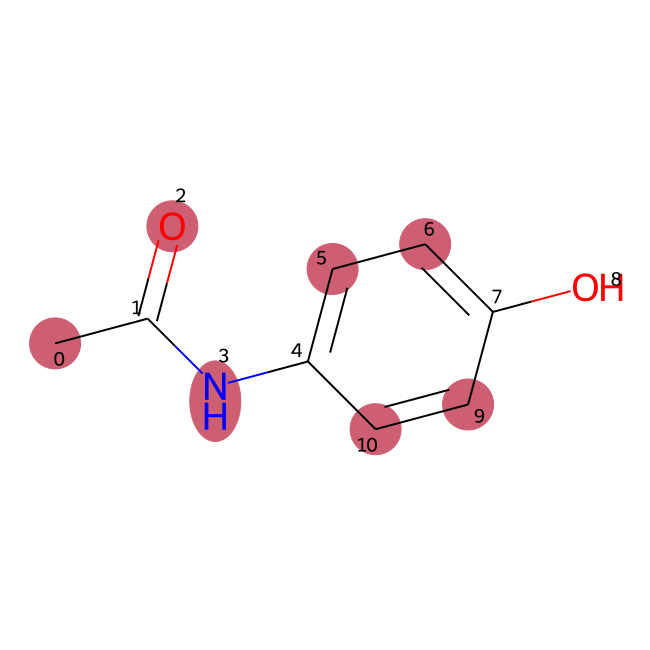

In [80]:
draw(gcn,dataset)

The nodes in graph is 22
At the 0 rollout, 181 states that have been explored.
At the 1 rollout, 317 states that have been explored.
At the 2 rollout, 430 states that have been explored.
At the 3 rollout, 578 states that have been explored.
At the 4 rollout, 702 states that have been explored.


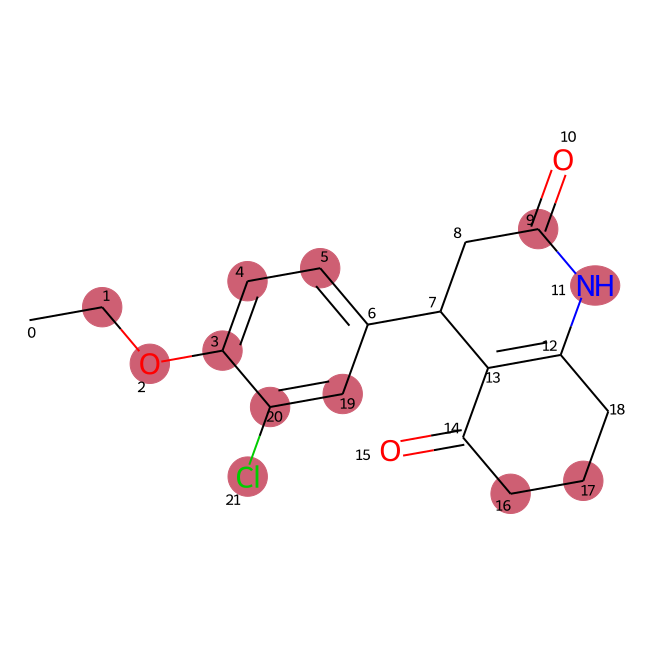

In [17]:
draw(graphsage,dataset)

The nodes in graph is 11
At the 0 rollout, 42 states that have been explored.
At the 1 rollout, 42 states that have been explored.
At the 2 rollout, 42 states that have been explored.
At the 3 rollout, 42 states that have been explored.
At the 4 rollout, 42 states that have been explored.


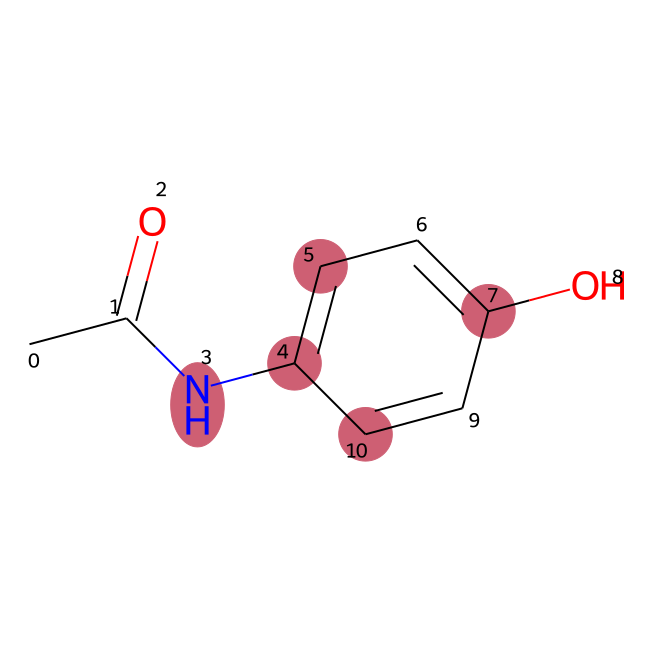

In [81]:
draw(gat,dataset)